### 某电信公司的课户流失数据集用户画像（特征选择）
XGBoost. 
如何选择哪个特征和特征值进行分裂，使最终我们的损失函数𝐿𝑡最小？
XGBoost这里不使用均方误差，而是使用贪心法，即每次分裂都期望最小化我们的损失函数的误差。


1. 将特征变数值型。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from  sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score,precision_score,recall_score,roc_curve

In [2]:
# 导入数据
tel = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
tel.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
tel=tel.drop_duplicates()

In [4]:
tel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


TotalCharges的Dtype为object型，需要转为 float64 
SeniorCitizen 

In [5]:
tel['TotalCharges']= pd.to_numeric(tel.TotalCharges, errors='coerce')
tel['SeniorCitizen'] = tel['SeniorCitizen'].astype("object")
tel['tenure'] = tel['tenure'].astype("object")
tel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   object 
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### 由于用户ID对分类没有意义

In [6]:
tel.drop(columns='customerID',inplace=True)


In [9]:
tel[tel.TotalCharges.isnull()==True]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [10]:
tel[tel.TotalCharges==tel.MonthlyCharges].shape[0]

613

从上式中可以知道，即使是新用户总的费用也是会被记录。而只有月度费用而没有总费用的用户，可以计为异常值。


In [11]:
tel.drop(index = tel[tel.TotalCharges.isnull()==True].index, axis=0,inplace = True)
# 去除异常值的行
tel = tel.reset_index(drop = True)

以用户的月度费用的等级进行分箱 

In [14]:
tel['MonthlyCharges']=pd.Series(pd.cut(tel.MonthlyCharges, 4, labels=[0,1,2,3]))
tel['TotalCharges']=pd.Series(pd.cut(tel.TotalCharges, 4, labels=[0,1,2,3]))
tel

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0,0,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1,0,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,1,0,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0,0,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,2,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,2,0,No
7028,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),3,3,No
7029,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,0,0,No
7030,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,2,0,Yes


In [15]:
tel.describe(include='all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,2,2,2,2,72,2,3,3,3,3,3,3,3,3,3,2,4,4,4,2
top,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,2,0,No
freq,3549,5890,3639,4933,613,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,2288,4305,5163


In [16]:
tel.Churn.value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

由于样品结果失衡，需要使得样本均匀，采用过采样的方法填补数据缺口。

In [18]:
labelencoder = LabelEncoder()


In [19]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

将数据的文本形式分类变成数值型，如：Partner，Dependent 都是以Yes，No 区分； InternetService 和 Contract 等 是三种类型。

In [20]:
for i in X.columns:
    X[i] = labelencoder.fit_transform(X[i])
Y= labelencoder.fit_transform(Y)

In [21]:
from imblearn.over_sampling import SMOTE
model_smote = SMOTE()
X,Y = model_smote.fit_resample(X,Y)

In [51]:
y= pd.Series(Y)
y.name = 'Churn'


# Correlation of Feature #

数据集中收集的特征可以分为三类：
#### 用户个人特征('gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure') ####
#### 公司提供的服务特征('PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies') #### 
####  合约特征('Contract', 'PaperlessBilling', 'PaymentMethod','MonthlyCharges', 'TotalCharges') #### 


In [73]:
cor = pd.merge(X,y,on= (X.index))

In [74]:
cor = cor.drop(columns='key_0')

In [75]:
cor = cor.corr(method='pearson', min_periods=1)

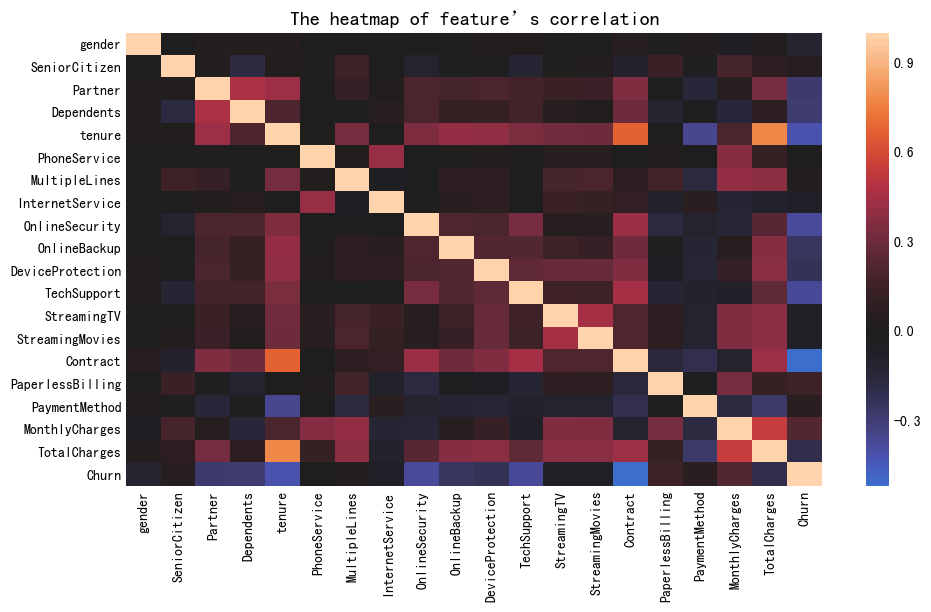

In [76]:

figure,ax = plt.subplots(figsize=(10,6),dpi=100)
ax.set_title('The heatmap of feature’s correlation')
sns_plot = sns.heatmap(cor,center = 0)
plt.show()

### 从颜色轴可以知道颜色越暗，相关性越低，反之亦然。
##### 1.看到Churn的行。性别gender，老年人seniorcitizen的特征与流失的关系微乎其微。tenure客户的职位，OnlineSecurity网络安全服务，techsupport技术支持服务，和最重要的Contract 合约类型的对流失有比较明显的影响。相关性只能说明与流失特征没有线型关系，并不完全代表没有因果关系。#####
##### 2.

## 数据划分训练集和测试集

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=0) 

In [23]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)}
param_test2 = {
    'gamma': [i / 10.0 for i in range(0, 5)]}
param_test3 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]}

In [23]:
gsearch = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8,  colsample_bytree=0.8, objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27),param_grid =param_test1,scoring='roc_auc',n_jobs=1, cv=5)
gsearch.fit(X_train ,y_train )
means = gsearch.cv_results_['mean_test_score']
params = gsearch.cv_results_['params']
print(means, params)

[0.89917238 0.8977751  0.89687773 0.89789913 0.89740325 0.89693946
 0.89745126 0.895106   0.89537012 0.89672536 0.89525379 0.89539033] [{'max_depth': 3, 'min_child_weight': 1}, {'max_depth': 3, 'min_child_weight': 3}, {'max_depth': 3, 'min_child_weight': 5}, {'max_depth': 5, 'min_child_weight': 1}, {'max_depth': 5, 'min_child_weight': 3}, {'max_depth': 5, 'min_child_weight': 5}, {'max_depth': 7, 'min_child_weight': 1}, {'max_depth': 7, 'min_child_weight': 3}, {'max_depth': 7, 'min_child_weight': 5}, {'max_depth': 9, 'min_child_weight': 1}, {'max_depth': 9, 'min_child_weight': 3}, {'max_depth': 9, 'min_child_weight': 5}]


{'max_depth': 3, 'min_child_weight': 1} 为最佳

In [24]:
gsearch = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8,  colsample_bytree=0.8, objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27),param_grid =param_test2,scoring='roc_auc',n_jobs=1, cv=5)
gsearch.fit(X_train ,y_train )
means1 = gsearch.cv_results_['mean_test_score']
params1 = gsearch.cv_results_['params']
print(means1, params1)

[0.89789913 0.89812497 0.89826802 0.89863875 0.89916013] [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}]


{'gamma': 0.4}

In [25]:
gsearch = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8,  colsample_bytree=0.8, objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27),param_grid =param_test3,scoring='roc_auc',n_jobs=1, cv=5)
gsearch.fit(X_train ,y_train )
means2 = gsearch.cv_results_['mean_test_score']
params2 = gsearch.cv_results_['params']
print(means2, params2)

[0.89741574 0.89710323 0.89863257 0.90034026 0.89851207 0.89754158
 0.89881058 0.89981904 0.89813852 0.8979527  0.89789913 0.89969833
 0.89720669 0.89811726 0.8978998  0.89881997] [{'colsample_bytree': 0.6, 'subsample': 0.6}, {'colsample_bytree': 0.6, 'subsample': 0.7}, {'colsample_bytree': 0.6, 'subsample': 0.8}, {'colsample_bytree': 0.6, 'subsample': 0.9}, {'colsample_bytree': 0.7, 'subsample': 0.6}, {'colsample_bytree': 0.7, 'subsample': 0.7}, {'colsample_bytree': 0.7, 'subsample': 0.8}, {'colsample_bytree': 0.7, 'subsample': 0.9}, {'colsample_bytree': 0.8, 'subsample': 0.6}, {'colsample_bytree': 0.8, 'subsample': 0.7}, {'colsample_bytree': 0.8, 'subsample': 0.8}, {'colsample_bytree': 0.8, 'subsample': 0.9}, {'colsample_bytree': 0.9, 'subsample': 0.6}, {'colsample_bytree': 0.9, 'subsample': 0.7}, {'colsample_bytree': 0.9, 'subsample': 0.8}, {'colsample_bytree': 0.9, 'subsample': 0.9}]


{'colsample_bytree': 0.8, 'subsample': 0.9}

In [24]:
param_dist ={'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.4,'colsample_bytree': 0.8, 'subsample': 0.9}

In [25]:
model_xgb = xgb.XGBClassifier(**param_dist)
model_xgb.fit(X_train,y_train)
pre_y = model_xgb.predict(X_test)

In [26]:
tn,fp,fn,tp = confusion_matrix(y_test,pre_y).ravel()

In [27]:
tn,fp,fn,tp

(1178, 364, 189, 1367)

In [28]:
from sklearn import metrics
accu_score = metrics.accuracy_score(y_test, pre_y)
pred_score = metrics.precision_score(y_test, pre_y)
recall_score = metrics.recall_score(y_test, pre_y)
f1_score = metrics.f1_score(y_test, pre_y)
y_score = model_xgb.predict_proba(X_test)
# ROC
fpr ,tpr, _ = roc_curve(y_test,y_score[:,1])
auc_s = auc(fpr,tpr)
print('查准率: ',pred_score)
print('accu: ',accu_score)
print('召回率: ',recall_score)
print('F1_score: ',f1_score)
print('AUC:',auc_s)

查准率:  0.7897169266320047
accu:  0.8214977404777276
召回率:  0.87853470437018
F1_score:  0.8317614846364466
AUC: 0.8977680223660387


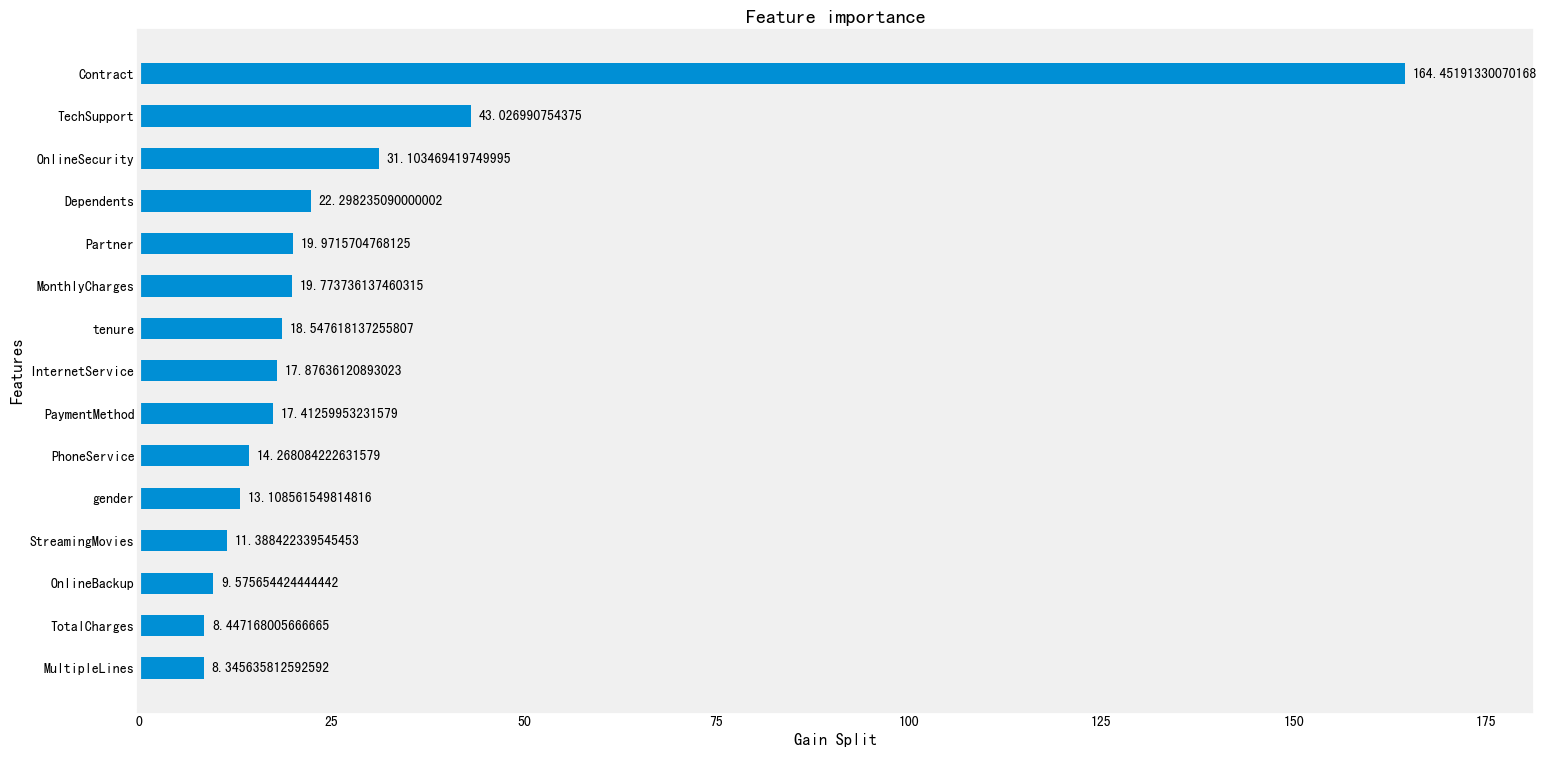

In [29]:
figure,ax = plt.subplots(figsize=(16,9),dpi=100) #
xgb.plot_importance(model_xgb,height=0.5,importance_type='gain',max_num_features=15,xlabel='Gain Split',grid=False,ax=ax)
plt.show()

In [ ]:
Contract, TechSupport,OnlineSecurity,Dependents,Partner,MonthlyCharges,tenure